# Mental Health Sentiment Analysis

In [77]:
import pandas as pd
import nltk
import torch
from datasets import Dataset
from transformers import BertTokenizer
import numpy as np
from sklearn.model_selection import train_test_split

In [72]:
df = pd.read_csv("./data/Combined Data.csv", index_col=0)

In [73]:
df

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety
...,...,...
53038,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety
53039,"selfishness ""I don't feel very good, it's lik...",Anxiety
53040,Is there any way to sleep better? I can't slee...,Anxiety
53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety


In [86]:
df = df.dropna()

In [113]:
labels = df['status'].unique().tolist()
labels

['Anxiety',
 'Normal',
 'Depression',
 'Suicidal',
 'Stress',
 'Bipolar',
 'Personality disorder']

In [118]:
label_to_id = {label: i for i, label in enumerate(labels)}
id_to_label = {i: label for i, label in enumerate(labels)}

label_to_id['Suicidal']
id_to_label[3]

'Suicidal'

In [116]:
df['status'] = df['status'].apply(lambda x : label_to_id[str(x)])

/var/folders/4s/pf1zdv_x4_qcflpq4m943q0m0000gn/T/ipykernel_29005/1510116700.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['status'] = df['status'].apply(lambda x : label_to_id[str(x)])


In [134]:
df = df.sample(5000, random_state=42)
df

,statement,status
3008,I'm lazy to complain about it ba ihh,1
44705,i think the wifi on my iphone is broken it wil...,1
50186,Good tracking apps? I've been trying to find a...,5
13755,I have recently looked into reddit and found t...,2
32298,that's your favorite thing to do?,1
...,...,...
46638,"I Am a Colorful Portrait of Bipolar, ADHD, Anx...",5
34815,Hi I’m new - hypochondriac for 3 years. Hi eve...,0
45559,"Best meds for me, I guess Lithium was the best...",5
38088,a year ago today i moved to a new city the cit...,2


In [146]:
df = df.rename(columns={'statement' : 'text', 'status' : 'labels'})
df

,text,labels
3008,I'm lazy to complain about it ba ihh,1
44705,i think the wifi on my iphone is broken it wil...,1
50186,Good tracking apps? I've been trying to find a...,5
13755,I have recently looked into reddit and found t...,2
32298,that's your favorite thing to do?,1
...,...,...
46638,"I Am a Colorful Portrait of Bipolar, ADHD, Anx...",5
34815,Hi I’m new - hypochondriac for 3 years. Hi eve...,0
45559,"Best meds for me, I guess Lithium was the best...",5
38088,a year ago today i moved to a new city the cit...,2


In [147]:
train_df, val_df = train_test_split(df, test_size=.2, random_state=42)

In [148]:
train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)

In [149]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [152]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

In [153]:
train_ds["text"]

['I feel so alone in this. No one to talk to, no one to laugh with, no one to go out and watch a movie together, no one I can tell my feelings to, no one to share my personal interests toThere must be something wrong with me It hurts knowing you have no one. At all. Absolutely nobody.',
 "i faced up to myself. i completed probation. it's not the drugs i need. it's to leave my environment and everything i know; it's to get a fresh start. i'm only 22.",
 'At 2am I will be hanging from the tree infrount of me and the pain of living will finally end i cannot wait I thought I would feel way more sad but I do not I do not feel anything just looking at the time and counting down I am here 12 hours from now the end',
 'brain brick',
 'i attended school today. did you?',
 "Did I have an anxiety attack? I was backing my vehicle into a parking spot as I usually do and I felt panic out of the blue. I felt as if my vehicle wasn't stopping so I slammed the brakes fearing I was about to hit the vehic

In [154]:
tokenized_train = train_ds.map(tokenize_function, batched=True)
tokenized_val = val_ds.map(tokenize_function, batched=True)

Map: 100%|██████████| 1000/1000 [00:01<00:00, 804.80 examples/s]


In [155]:
from transformers import BertForSequenceClassification, TrainingArguments, Trainer

# Initialize model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(labels)
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [164]:
training_args = TrainingArguments(
    output_dir="./results/run1",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

/opt/anaconda3/envs/mental_health_proj/lib/python3.10/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [165]:
import numpy as np
import evaluate

metric = evaluate.load("f1")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average="macro")

In [166]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics,
)

In [167]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,No log,0.656934,0.764503
2,0.180300,0.853999,0.749274
3,0.180300,1.009352,0.732952
4,0.068100,1.096921,0.740643
5,0.068100,1.112623,0.743907


TrainOutput(global_step=1250, training_loss=0.1037010829925537, metrics={'train_runtime': 1657.5351, 'train_samples_per_second': 12.066, 'train_steps_per_second': 0.754, 'total_flos': 1315614336000000.0, 'train_loss': 0.1037010829925537, 'epoch': 5.0})

In [168]:
evaluation_results = trainer.evaluate()
print(f"Evaluation results: {evaluation_results}")

Evaluation results: {'eval_loss': 0.6569341421127319, 'eval_f1': 0.7645033545059577, 'eval_runtime': 21.1107, 'eval_samples_per_second': 47.369, 'eval_steps_per_second': 2.984, 'epoch': 5.0}


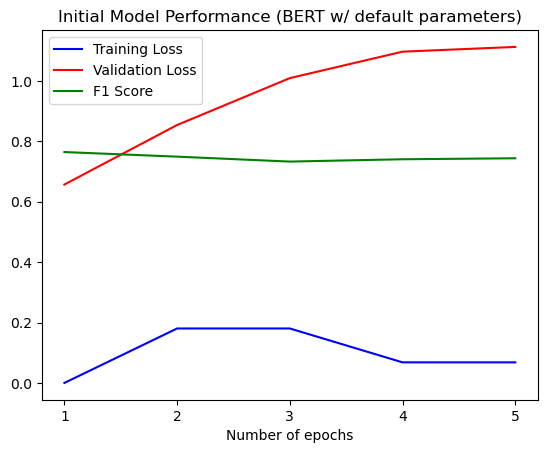

In [174]:
import matplotlib.pyplot as plt

epoch_list = [1,2,3,4,5]
train_l_list = [0,.1803,.1803,.0681,.0681]
val_l_list = [.656934, .853999, 1.009352, 1.096921, 1.112623]
f1_list = [0.764503, 0.749274, 0.732952, 0.740643, 0.743907]

plt.plot(epoch_list, train_l_list, c='b', label='Training Loss')
plt.plot(epoch_list, val_l_list, c='r', label='Validation Loss')
plt.plot(epoch_list, f1_list, c='g', label='F1 Score')

plt.title("Initial Model Performance (BERT w/ default parameters)")
plt.xlabel("Number of epochs")
plt.xticks([1,2,3,4,5])
plt.legend()
plt.show()

In [50]:
tt_split = dataset.train_test_split(test_size=0.2, seed=42)
test_val_split = tt_split['test'].train_test_split(test_size=.5, seed=42)
ttv_dataset = DatasetDict({
    'train': tt_split['train'],
    'test': test_val_split['test'],
    'validation': test_val_split['train']})


In [51]:
key_list = [key for key in ttv_dataset['train'].features.keys() if key not in ['statement', '__index_level_0__']]
key_list

['Anxiety',
 'Bipolar',
 'Depression',
 'Normal',
 'Personality Disorder',
 'Stress',
 'Suicidal']

In [52]:
id2key = {idx:key for idx, key in enumerate(key_list)}
key2id = {key:idx for idx, key in enumerate(key_list)}

In [53]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [54]:
def preprocessing(textset):
    #print(len(textset['statement']))
    #print(textset)
    encoded_text = tokenizer(textset['statement'])
    labels_batch = {k: textset[k] for k in textset.keys() if k in key_list}
    labels_matrix = np.zeros((len(textset['statement']), len(key_list)))
    #print(labels_matrix.shape)
    #for label in key_list:
        #print(f"Label: {label}, Shape: {np.array(labels_batch[label]).shape}")
    for idx, label in enumerate(key_list):
        labels_matrix[:, idx] = labels_batch[label]
    encoded_text["labels"] = labels_matrix.tolist()
    return encoded_text

In [55]:
ttv_dataset['train'][0]

{'statement': 'I cheated on my now ex. I hid the fact that I was talking to two other people. I went on a few dates with one of them. Nothing sexual or physical ever happened with either, but I cheated through and through. I lied to my ex so many times, right to their face. Even now I have not come clean. I ruined a great relationship for no good reason and really hurt someone. I do not think I can ever live this down or forgive myself for what I did. I cheated',
 'Anxiety': False,
 'Bipolar': False,
 'Depression': False,
 'Normal': False,
 'Personality Disorder': False,
 'Stress': False,
 'Suicidal': True,
 '__index_level_0__': 23510}

In [56]:
encoded_data = ttv_dataset.map(preprocessing, batched=True, remove_columns=ttv_dataset['train'].column_names)

Map:   0%|          | 0/42144 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (919 > 512). Running this sequence through the model will result in indexing errors
Map: 100%|██████████| 5268/5268 [00:00<00:00, 10452.26 examples/s]


In [57]:
encoded_data['train'][0].keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])

In [58]:
tokenizer.decode(encoded_data['train'][0]['input_ids'])

'[CLS] i cheated on my now ex. i hid the fact that i was talking to two other people. i went on a few dates with one of them. nothing sexual or physical ever happened with either, but i cheated through and through. i lied to my ex so many times, right to their face. even now i have not come clean. i ruined a great relationship for no good reason and really hurt someone. i do not think i can ever live this down or forgive myself for what i did. i cheated [SEP]'

In [59]:
encoded_data['train'][0]['labels']

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]

In [60]:
[id2key[idx] for idx, label in enumerate(encoded_data['train'][0]['labels']) if label == 1.0]

['Suicidal']

In [61]:
encoded_data.set_format("torch")

In [62]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased",
                                                           num_labels=len(key_list),
                                                           id2label=id2key,
                                                           label2id=key2id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [63]:
batch_size = 8
metric_name = "f1"

In [64]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    f"bert-finetuned-sem_eval-english",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    #push_to_hub=True,
)

/opt/anaconda3/envs/mental_health_proj/lib/python3.10/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [65]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
import torch
    
# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        labels=p.label_ids)
    return result

In [66]:
encoded_data['train'][0]['labels'].type()

'torch.FloatTensor'

In [67]:
encoded_data['train']['input_ids'][0]

tensor([  101,  1045, 22673,  2006,  2026,  2085,  4654,  1012,  1045, 11041,
         1996,  2755,  2008,  1045,  2001,  3331,  2000,  2048,  2060,  2111,
         1012,  1045,  2253,  2006,  1037,  2261,  5246,  2007,  2028,  1997,
         2068,  1012,  2498,  4424,  2030,  3558,  2412,  3047,  2007,  2593,
         1010,  2021,  1045, 22673,  2083,  1998,  2083,  1012,  1045,  9828,
         2000,  2026,  4654,  2061,  2116,  2335,  1010,  2157,  2000,  2037,
         2227,  1012,  2130,  2085,  1045,  2031,  2025,  2272,  4550,  1012,
         1045,  9868,  1037,  2307,  3276,  2005,  2053,  2204,  3114,  1998,
         2428,  3480,  2619,  1012,  1045,  2079,  2025,  2228,  1045,  2064,
         2412,  2444,  2023,  2091,  2030,  9641,  2870,  2005,  2054,  1045,
         2106,  1012,  1045, 22673,   102])

In [68]:
#forward pass
outputs = model(input_ids=encoded_data['train']['input_ids'][0].unsqueeze(0), labels=encoded_data['train'][0]['labels'].unsqueeze(0))
outputs

SequenceClassifierOutput(loss=tensor(0.6050, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), logits=tensor([[-0.7911,  0.5452, -0.0509, -0.6545, -0.0234, -0.7233, -0.0039]],
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [69]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_data["train"],
    eval_dataset=encoded_data["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/var/folders/4s/pf1zdv_x4_qcflpq4m943q0m0000gn/T/ipykernel_29005/213723154.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [70]:
trainer.train()

Epoch,Training Loss,Validation Loss


RuntimeError: The size of tensor a (744) must match the size of tensor b (512) at non-singleton dimension 1

In [3]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')
